# NHL Flames - Event Propensity Model
* Ryan Kazmerik & Joey Lai
* Oct 14, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

from pycaret.classification import *
from shared_utilities import helpers

### Let's connect to RedShift and run a stored proc to get our dataset:

In [68]:
CLUSTER = "prod-app"
DATABASE = "stlryankees"
LKUPCLIENTID = "53"

In [69]:
df = helpers.get_event_propensity_training_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    start_year=2010,
    end_year=2021
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


In [ ]:
df_train = df
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62212 entries, 0 to 62211
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   daysout              62212 non-null  object        
 1   mindaysout           62212 non-null  int64         
 2   maxdaysout           34058 non-null  float64       
 3   dimcustomermasterid  62212 non-null  int64         
 4   recent_openrate      62212 non-null  float64       
 5   recent_clickrate     62212 non-null  float64       
 6   eventdate            62212 non-null  datetime64[ns]
 7   eventname            62212 non-null  object        
 8   inmarket             59194 non-null  object        
 9   distancetovenue      58721 non-null  float64       
 10  tenure               62212 non-null  int64         
 11  did_purchase         62212 non-null  int64         
 12  events_purchased     62212 non-null  int64         
 13  frequency_opponent   62212 non-

In [ ]:
df_train.head()

,daysout,mindaysout,maxdaysout,dimcustomermasterid,recent_openrate,recent_clickrate,eventdate,eventname,inmarket,distancetovenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,count_merchowned
0,Over a Week,8,NaN,156577,0.0,0.0,2016-01-12,20160112 - San Jose Sharks,True,6.97,445,1,59,0.0,0.000000,0.020408,0
1,4 to 7 Days Out,4,8.0,156727,0.0,0.0,2021-10-23,20211023 - Nashville Predators,False,511.43,1040,1,66,0.0,0.000000,0.016949,0
2,Day Of,0,1.0,157119,0.0,0.0,2018-12-16,20181216 - Tampa Bay Lightning,False,594.02,426,1,60,0.0,0.000000,0.018182,0
3,Over a Week,8,NaN,158149,0.0,0.0,2015-03-26,20150326 - Montreal Canadiens,False,1654.49,474,1,65,0.0,0.111111,0.035088,0
4,Over a Week,8,NaN,158149,0.0,0.0,2016-01-26,20160126 - Arizona Coyotes,False,1654.49,780,1,97,0.5,0.047619,0.071429,0


### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [ ]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.90,
    data_split_shuffle=True,
    ignore_features=[
        "count_merchowned",
        "dimcustomermasterid",
        "eventdate",
        "eventname",
        "inmarket",
        "mindaysout",
        "maxdaysout"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distancetovenue",
        "events_purchased",
        "frequency_eventday",
        "frequency_opponent",
        "frequency_eventtime",
        "recent_clickrate",
        "recent_openrate",
        "tenure"
    ]
);

In [ ]:
model_matrix = compare_models(
    fold= 10, 
    include= ["lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7345,0.8145,0.7202,0.7412,0.7305,0.4690,0.4692,0.4710


### The top model is performing well, so let's compare it against our test dataset:

In [ ]:
final_model = create_model(model_matrix, fold= 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7335,0.8163,0.7105,0.7446,0.7271,0.4670,0.4675
1,0.7435,0.8161,0.7320,0.7491,0.7404,0.4870,0.4872
2,0.7273,0.8126,0.7148,0.7329,0.7237,0.4545,0.4547
3,0.7387,0.8131,0.7227,0.7464,0.7343,0.4774,0.4776
4,0.7371,0.8187,0.7291,0.7407,0.7349,0.4742,0.4742
5,0.7330,0.8072,0.7191,0.7394,0.7291,0.4660,0.4661
6,0.7282,0.8063,0.7119,0.7356,0.7236,0.4563,0.4566
7,0.7362,0.8174,0.7224,0.7428,0.7325,0.4724,0.4726
8,0.7389,0.8248,0.7278,0.7442,0.7359,0.4778,0.4779


### We can also see the correlation between the features and the target variable:

In [ ]:
cor = df.corr()

df_correlated = df

corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,mindaysout,maxdaysout,dimcustomermasterid,recent_openrate,recent_clickrate,distancetovenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,count_merchowned
mindaysout,1.00,0.98,0.04,-0.02,-0.02,0.02,-0.06,0.35,-0.04,0.13,0.13,0.12,0.01
maxdaysout,0.98,1.00,-0.08,0.00,-0.00,0.01,0.03,-0.11,0.03,-0.02,-0.02,-0.04,0.01
dimcustomermasterid,0.04,-0.08,1.00,-0.01,-0.01,0.13,-0.09,0.26,-0.08,0.20,0.27,0.33,-0.02
recent_openrate,-0.02,0.00,-0.01,1.00,0.66,-0.01,0.01,-0.00,0.02,-0.01,-0.00,0.00,0.00
recent_clickrate,-0.02,-0.00,-0.01,0.66,1.00,-0.01,0.03,-0.01,0.03,-0.01,-0.00,-0.00,0.01
distancetovenue,0.02,0.01,0.13,-0.01,-0.01,1.00,0.00,0.06,0.02,0.01,-0.00,0.00,-0.03
tenure,-0.06,0.03,-0.09,0.01,0.03,0.00,1.00,-0.22,0.97,-0.03,-0.16,-0.22,0.09
did_purchase,0.35,-0.11,0.26,-0.00,-0.01,0.06,-0.22,1.00,-0.19,0.22,0.26,0.29,0.01
events_purchased,-0.04,0.03,-0.08,0.02,0.03,0.02,0.97,-0.19,1.00,-0.01,-0.14,-0.20,0.06
frequency_opponent,0.13,-0.02,0.20,-0.01,-0.01,0.01,-0.03,0.22,-0.01,1.00,0.31,0.34,-0.01


### This plot lists the most important features for a correct prediction (either Score_0 or Score_1) in the model:

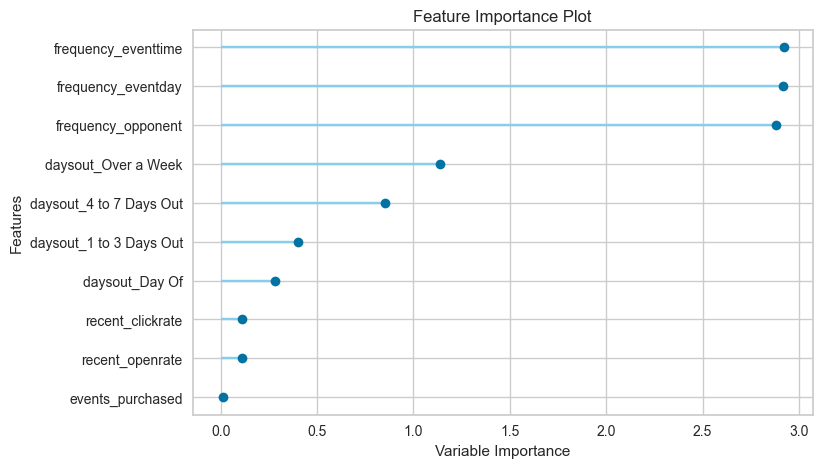

In [ ]:
plot_model(final_model, plot='feature')

### This confusion matrix helps understand where the model guessed correctly or incorrectly based on the evaluation data:

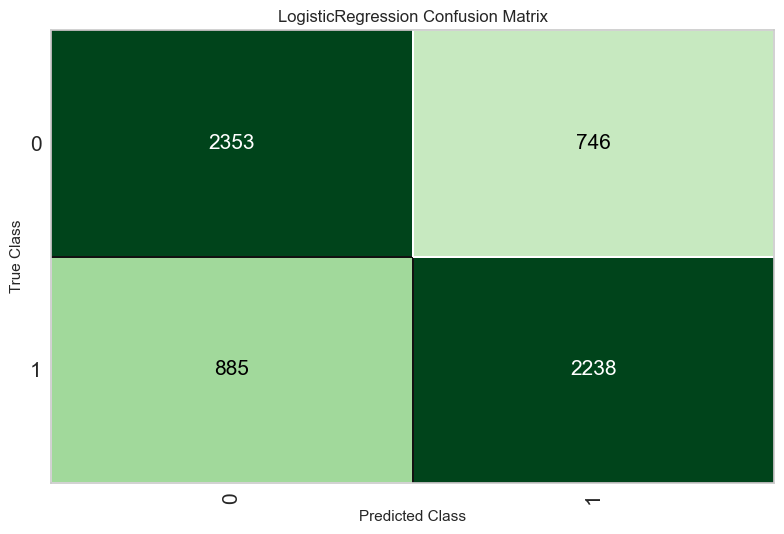

In [ ]:
plot_model(final_model, plot='confusion_matrix')

### The AUC curve tells how much the model is capable of distinguishing between classes. The higher the curve, the better the model is at distiguishing classes:

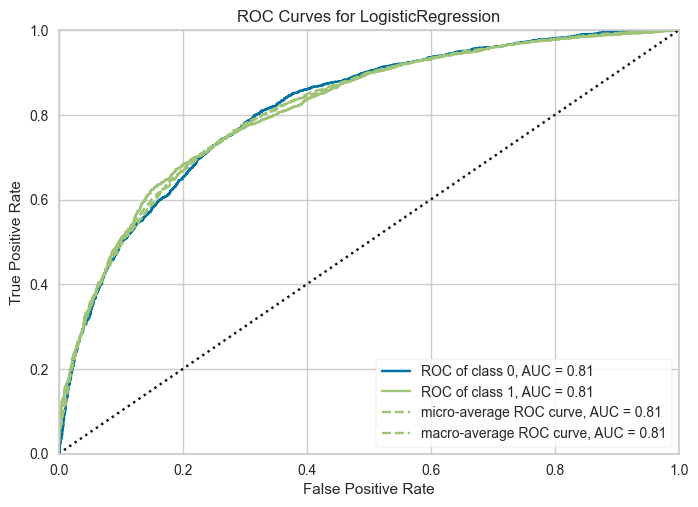

In [ ]:
plot_model(final_model, plot='auc')

### Let's load up some real events from previous events to see how the model scores the data:

In [ ]:
df_inference = helpers.get_event_propensity_scoring_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    game_date="2022-10-22"
)

df_inference.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(199388, 12)

In [ ]:
df_inference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199388 entries, 0 to 199387
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   daysOut              199388 non-null  object 
 1   eventDate            199388 non-null  object 
 2   tenure               199388 non-null  int64  
 3   dimCustomerMasterId  199388 non-null  int64  
 4   events_purchased     199388 non-null  float64
 5   frequency_opponent   10352 non-null   float64
 6   frequency_eventDay   41468 non-null   float64
 7   frequency_eventTime  184624 non-null  float64
 8   inMarket             177028 non-null  object 
 9   distanceToVenue      173872 non-null  float64
 10  recent_openRate      54148 non-null   float64
 11  recent_clickRate     54148 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 18.3+ MB


In [ ]:
# RENAMING SOME COLUMNS:
df_inference = df_inference.rename(columns={
    "daysOut": "daysout", "dimCustomerMasterId": "dimcustomermasterid","eventDate": "eventdate","frequency_eventDay":"frequency_eventday","frequency_eventTime":"frequency_eventtime","inMarket":"inmarket","distanceToVenue":"distancetovenue","recent_openRate":"recent_openrate","recent_clickRate":"recent_clickrate"
})

### Let's run the previous scores through the model for predictions:

In [ ]:
df_scores = predict_model(final_model, data=df_inference, raw_score=True)
df_scores.head()

,daysout,eventdate,tenure,dimcustomermasterid,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,inmarket,distancetovenue,recent_openrate,recent_clickrate,Label,Score_0,Score_1
0,Day Of,2022-10-22,2769,274681,1.0,NaN,NaN,1.0,False,202.44,NaN,NaN,0,0.8349,0.1651
1,1 to 3 Days Out,2022-10-22,2769,274681,1.0,NaN,NaN,1.0,False,202.44,NaN,NaN,0,0.8506,0.1494
2,4 to 7 Days Out,2022-10-22,2769,274681,1.0,NaN,NaN,1.0,False,202.44,NaN,NaN,0,0.8996,0.1004
3,Over a Week,2022-10-22,2769,274681,1.0,NaN,NaN,1.0,False,202.44,NaN,NaN,0,0.5501,0.4499
4,Day Of,2022-10-22,2962,232337,38.0,1.0,1.0,1.0,False,204.21,NaN,NaN,1,0.0211,0.9789


### Included are some metrics on did and did_not purchase:

In [ ]:
did_purchase = df_scores["Label"].value_counts()[1]
did_not_purchase = df_scores["Label"].value_counts()[0]
total_rows = df_scores["Label"].count()
purchase_percentage = round((did_purchase / total_rows) * 100, 2)

print(f"Would purchase: {did_purchase}")
print(f"Would not purchase: {did_not_purchase}")
print(f"Purchase percentage: {purchase_percentage}")

Would purchase: 128636
Would not purchase: 70752
Purchase percentage: 64.52


### Here we can see the distribution of fans who did and did not purchase : Score_0 = Did Not Purchase, Score_1 = Did Purchase

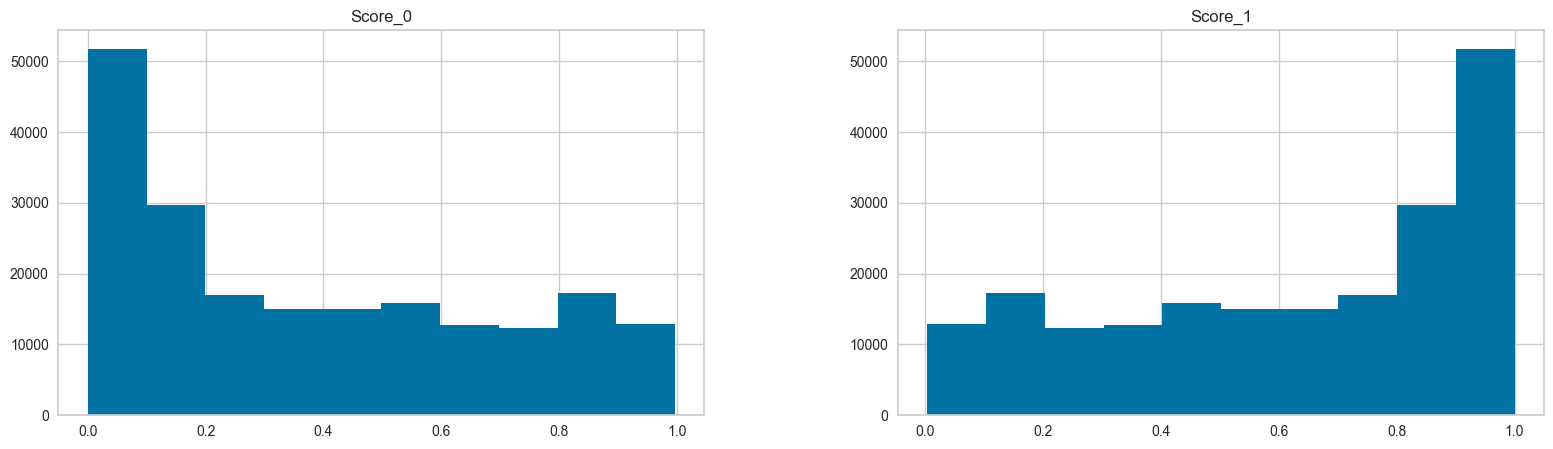

In [ ]:
df_scores.hist(column=['Score_0', 'Score_1'], figsize=(30,5), layout=(1,3));

## Observations
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?